Total amount of images: 354
Dataset contains 708 image pairs
Train contains 566 image pairs
Validation contains 70 image pairs
Test contains 72 image pairs


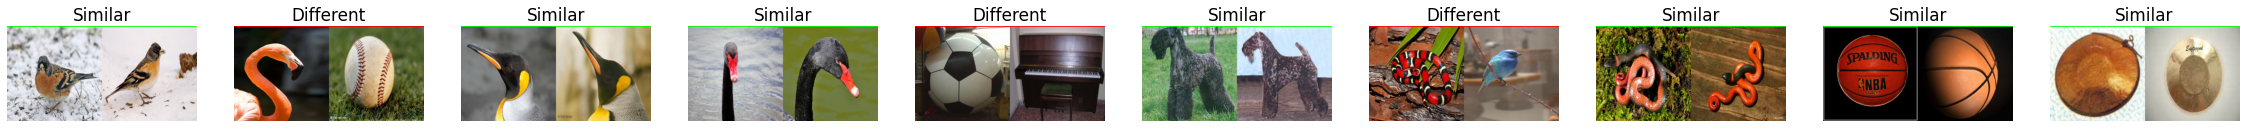

In [1]:
import sys
sys.path.append('../../utility')
import util
import numpy as np

folders = util.load_images('../../data/dataset_pairs')
data, labels = util.create_pairs(folders)
data, labels = util.shuffle_data(data, labels)
data_split, labels_split = util.split_data(data, labels)
data_train, data_val, data_test = data_split
labels_train, labels_val, labels_test = labels_split

print('Dataset contains', data.shape[0], 'image pairs')
print('Train contains', data_train.shape[0], 'image pairs')
print('Validation contains', data_val.shape[0], 'image pairs')
print('Test contains', data_test.shape[0], 'image pairs')

util.visualize(data_train, labels_train)

In [2]:
from keras.layers import GlobalAveragePooling2D, Input, Dot
from keras.models import Sequential, Model
from keras.applications.mobilenet_v2 import MobileNetV2

input_shape = (224, 224, 3)

mobilenet_embedding = Sequential(name='mobilenet_embedding')
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
mobilenet.Trainable = False
mobilenet_embedding.add(mobilenet)
mobilenet_embedding.add(GlobalAveragePooling2D())

mobilenet_embedding.compile()

# Input pair
input_image_1 = Input(input_shape)
input_image_2 = Input(input_shape)

# Output pair
encoded_image_1 = mobilenet_embedding(input_image_1)
encoded_image_2 = mobilenet_embedding(input_image_2)

similarity = Dot(axes=(1), normalize=True)([encoded_image_1, encoded_image_2])

# Full Model
siamese = Model(inputs=[input_image_1, input_image_2], outputs=similarity, name='model')
siamese.compile()

In [3]:
similarity = util.get_similarity_from_embedding(mobilenet_embedding, data)

similarity2 = []

for i in range(len(similarity)):
    similarity2.append(siamese([np.expand_dims(data[i][0], axis=0), np.expand_dims(data[i][1], axis=0)]).numpy()[0])

Took 59.01 seconds to predict 708 image pairs
Prediction time: 0.08 seconds


mobilenet
- Amount of TP: 336
- Amount of TN: 353
- Amount of FP: 1
- Amount of FN: 18
- AUC score: 0.9991301988572888
- Accuracy: 0.9731638418079096
- Recall: 0.9491525423728814
- Precision: 0.9970326409495549
- F1: 0.9725036179450074
- Kappa: 0.9463276836158192


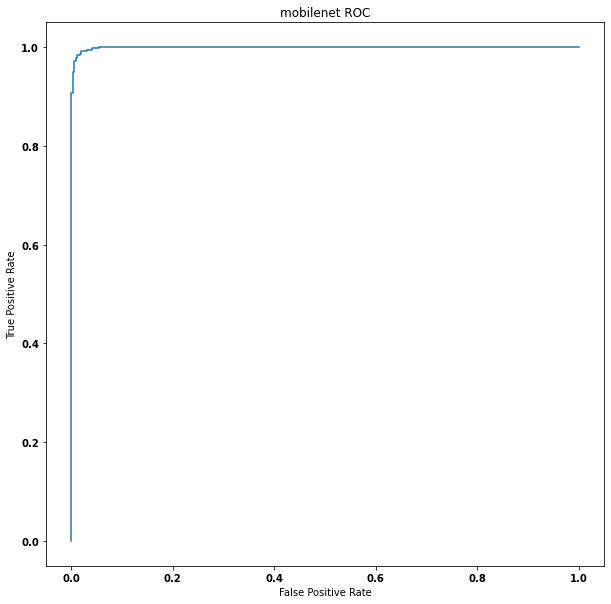

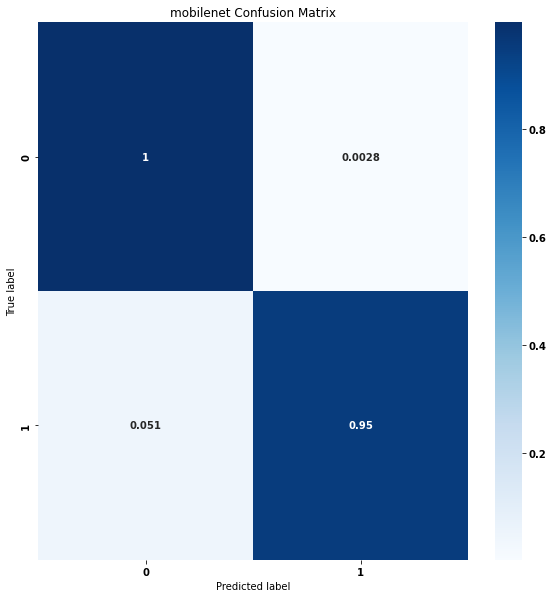

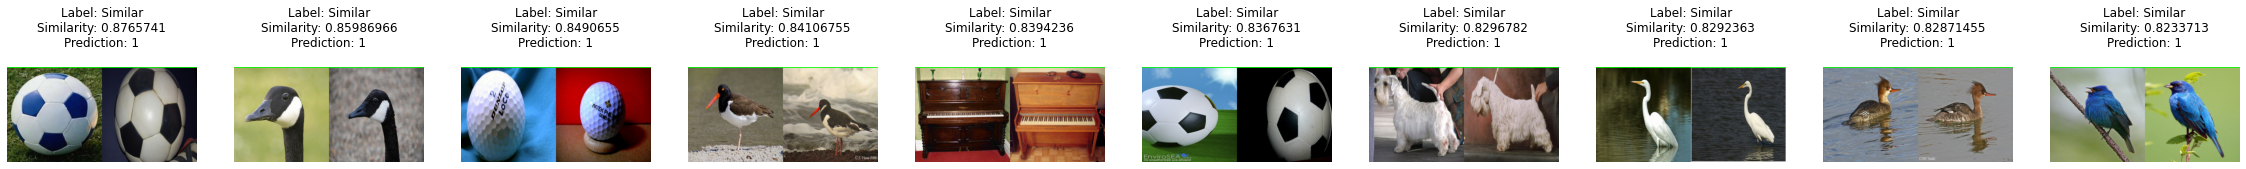

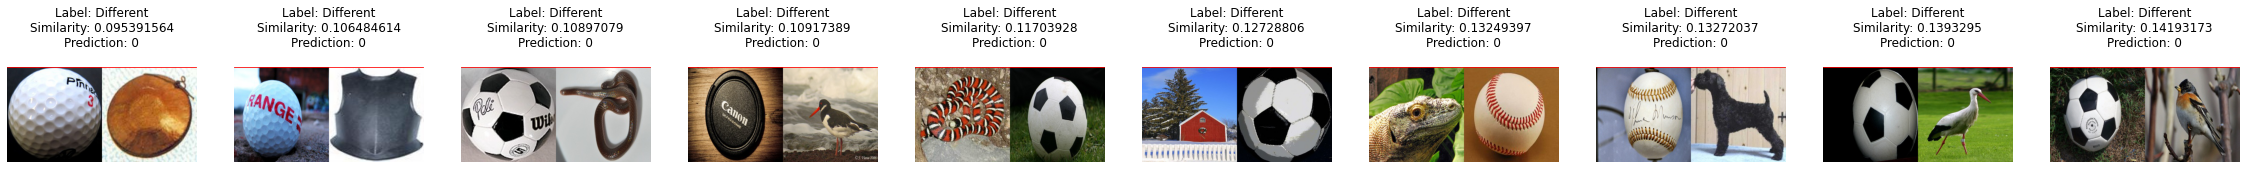

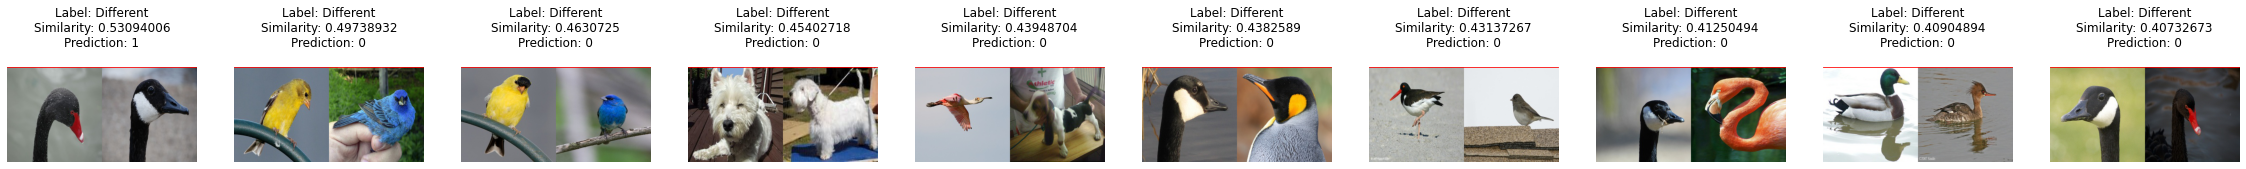

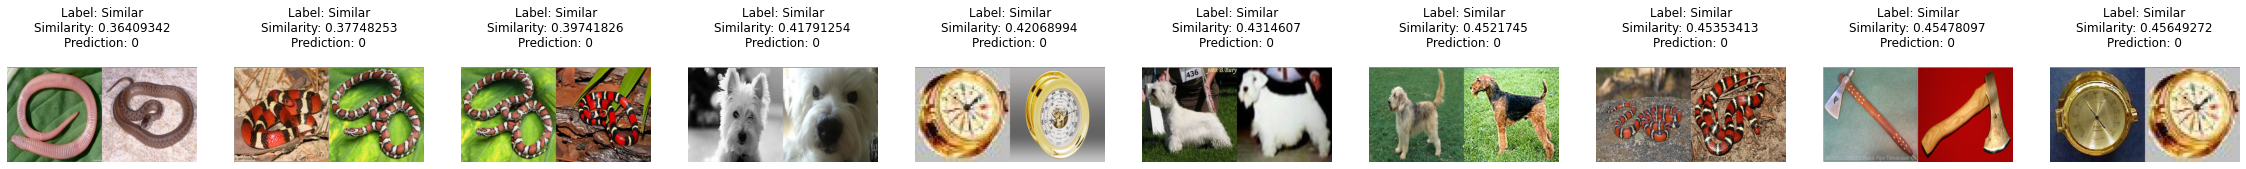

Threshold:  0.5


In [10]:
util.evaluate(data=data, labels=labels, similarity=similarity, name="mobilenet", threshold=0.5)

siamese
- Amount of TP: 336
- Amount of TN: 353
- Amount of FP: 1
- Amount of FN: 18
- AUC score: 0.9991301988572888
- Accuracy: 0.9731638418079096
- Recall: 0.9491525423728814
- Precision: 0.9970326409495549
- F1: 0.9725036179450074
- Kappa: 0.9463276836158192


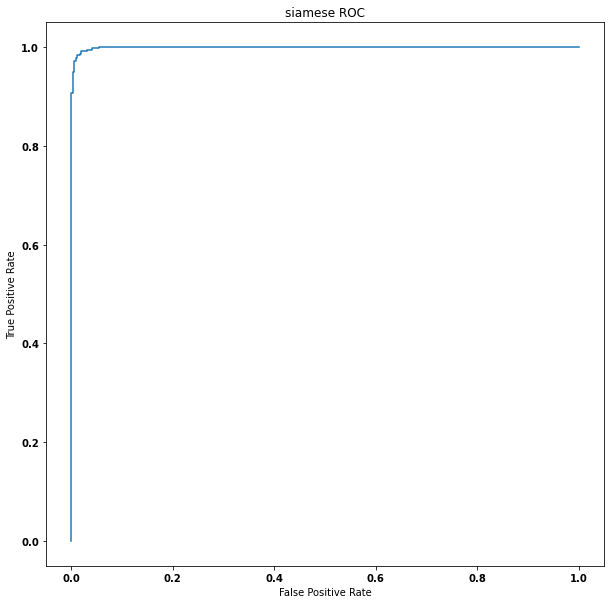

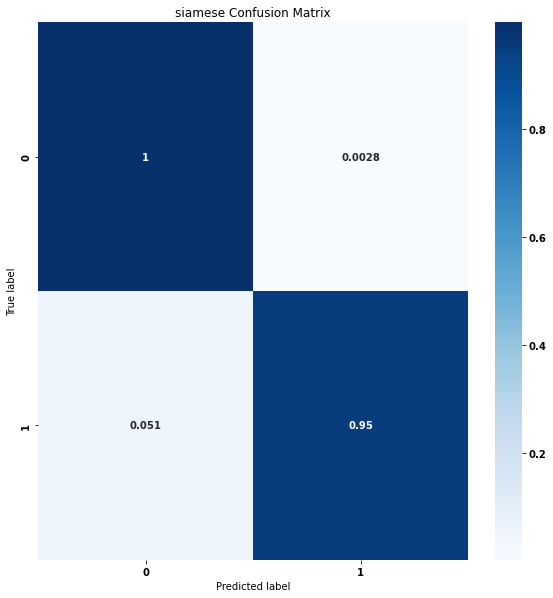

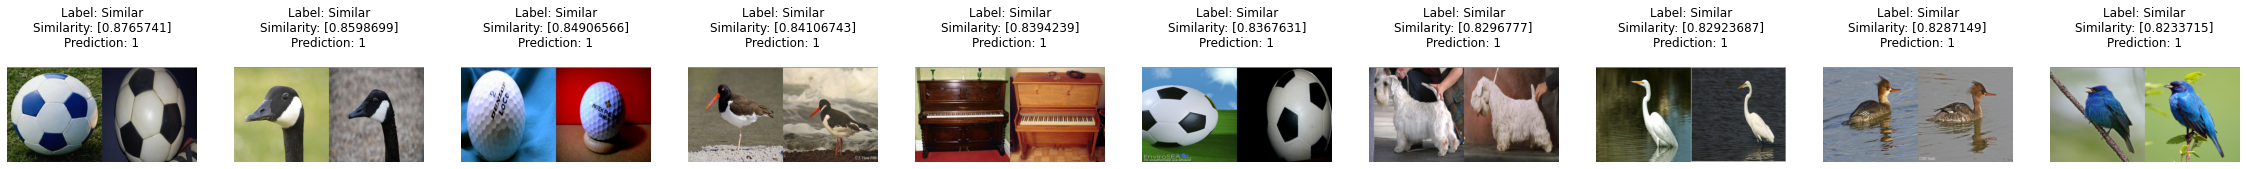

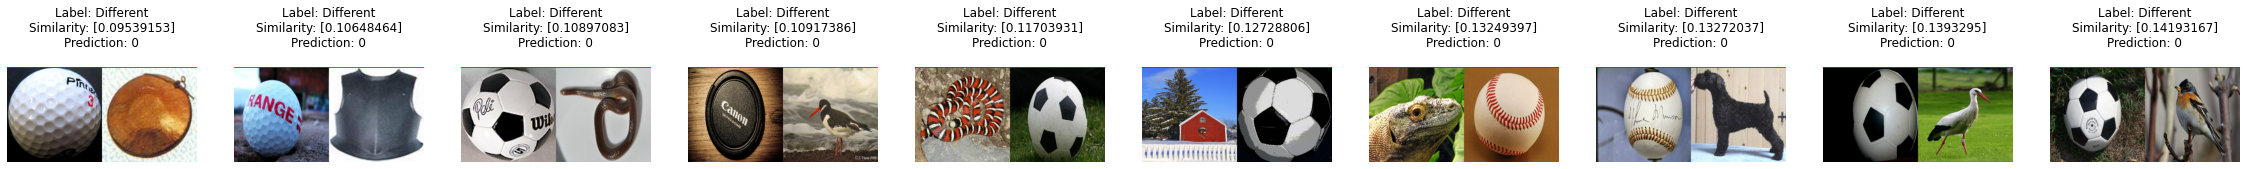

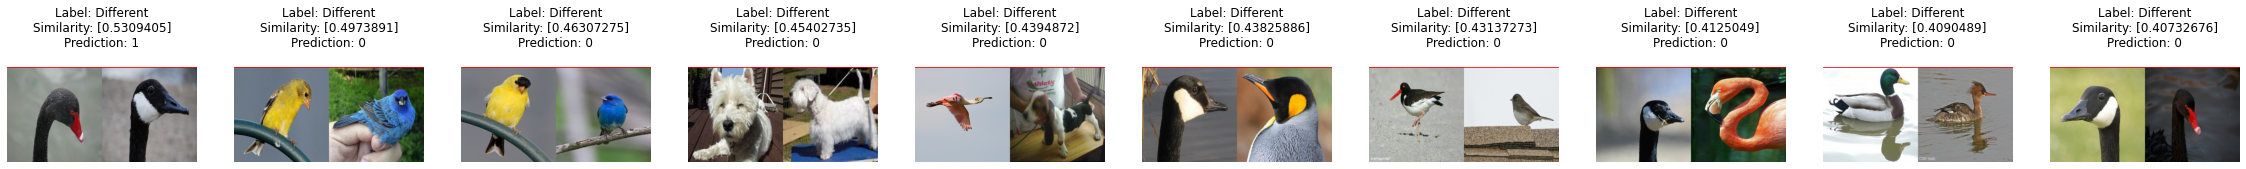

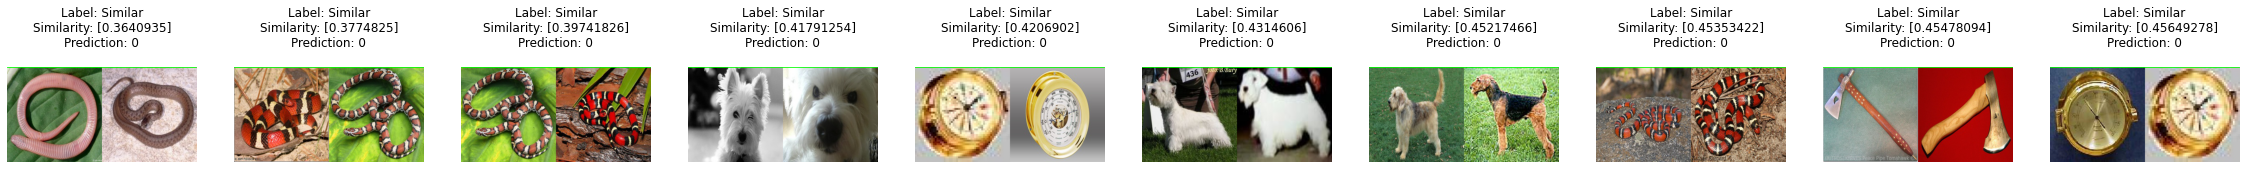

Threshold:  0.5


In [11]:
util.evaluate(data=data, labels=labels, similarity=similarity2, name="siamese", threshold=0.5)

Model: "mobilenet_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 2,257,984
Trainable params: 2,223,872
Non-trainable params: 34,112
_________________________________________________________________


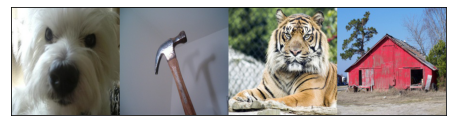

24.721592
22.682808
24.294048
23.064272
25.466902
23.11911


In [6]:
img1 = data_test[5][0]
img2 = data_test[5][1]
img3 = data_test[1][0]
img4 = data_test[1][1]

from keras.models import load_model

embedding_extractor = load_model('./pretrained_mobilenet_embedding_extractor.h5')

embedding_extractor.summary()

import numpy as np

util.visualize_images(img1, img2, img3, img4)

feature1 = embedding_extractor.predict(np.expand_dims(img1, axis=0))
feature2 = embedding_extractor.predict(np.expand_dims(img2, axis=0))
feature3 = embedding_extractor.predict(np.expand_dims(img3, axis=0))
feature4 = embedding_extractor.predict(np.expand_dims(img4, axis=0))

distance1 = util.euclidean_distance(feature1, feature2).numpy()[0][0]
distance2 = util.euclidean_distance(feature1, feature3).numpy()[0][0]
distance3 = util.euclidean_distance(feature1, feature4).numpy()[0][0]
distance4 = util.euclidean_distance(feature2, feature3).numpy()[0][0]
distance5 = util.euclidean_distance(feature2, feature4).numpy()[0][0]
distance6 = util.euclidean_distance(feature3, feature4).numpy()[0][0]

print(distance1)
print(distance2)
print(distance3)
print(distance4)
print(distance5)
print(distance6)

In [7]:
mobilenet_embedding.save('./pretrained_mobilenet_embedding_extractor.h5')

In [8]:
siamese.save('./pretrained_mobilenet_siamese.h5')

In [9]:
!tensorflowjs_converter --input_format keras --weight_shard_size_bytes 1073741824 ./pretrained_mobilenet_embedding_extractor.h5 .